# Basic GAN - MNIST

In [1]:
import os
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [2]:
torch.__version__

'1.11.0'

In [3]:
os.makedirs("samples", exist_ok=True)

## Hyper Parameters

In [4]:
epoch =0  # "epoch to start training from"
n_epochs = 100 # "number of epochs of training"
batch_size = 64 # "size of the batches"
lr = 0.0002 # "adam: learning rate"
b1 = 0.5 # "adam: decay of first order momentum of gradient"
b2 = 0.999 # "adam: decay of first order momentum of gradient"
n_cpu = 4 # "number of cpu threads to use during batch generation"
img_height = 28 # "size of image height"
img_width = 28 # "size of image width"
channels = 1 # "number of image channels"
z_dim = 100 # "dim of latent z"
sample_interval = 1 # "interval between sampling of images from generators"

## Data setting

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# imgage size
img_shape = (channels, img_width, img_height)
img_dim = img_width * img_height 
    
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='../mnist_data/', train=True, transform=transform, download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    num_workers=n_cpu,
    shuffle=True
)

## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, output_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

## Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [8]:
# build network
generator = Generator(input_dim=z_dim, output_dim=img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

# loss
adversarial_loss = nn.BCELoss().to(device)

# optimizer
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

## Generator Loss

#### generator loss
1. Generate Random noise z

2. Generator makes fake image using noise z

3. Discriminator evaluate whether this image is fake or real

4. Calculate generator loss

In [9]:
def generator_loss(generator):
    z = torch.randn(batch_size, z_dim).to(device)
    valid = torch.ones(batch_size, 1).to(device)
    
    # Generator loss
    fake_G = generator(z)
    pred_fake = discriminator(fake_G)
    G_loss = adversarial_loss(pred_fake, valid)

    return G_loss

## Discriminator Loss

#### real Loss
1. Discriminator evaluate whether real image is fake or real

2. Calculate fake loss


#### fake Loss
1. Generator makes fake image using Random noise z

2. Discriminator evaluate whether this fake image is fake or real

3. Calculate fake loss

In [10]:
def discriminator_loss(discriminator, real_imgs):
    valid = torch.ones(real_imgs.size(0), 1).to(device)
    fake = torch.zeros(real_imgs.size(0), 1).to(device)
        
    # real Loss
    pred_real = discriminator(real_imgs)
    D_real_loss = adversarial_loss(pred_real, valid)

    # fake Loss
    z = torch.randn(real_imgs.size(0), z_dim).to(device)
    fake_G = generator(z)
            
    pred_fake = discriminator(fake_G)
    D_fake_loss = adversarial_loss(pred_fake, fake)
    
    return D_real_loss + D_fake_loss

## Train

#### Training Process
1. Train Generator
2. Train Discriminator

In [ ]:
for epoch in range(epoch, n_epochs):
    for i, (imgs, _) in enumerate(train_loader):
            
        # Configure input
        real_imgs = imgs.view(imgs.size(0), -1).to(device)
            
        # ------------------
        #  Train Generators
        # ------------------
        G_optimizer.zero_grad()
        
        G_loss = generator_loss(generator) 
        G_loss.backward()
        G_optimizer.step()
    
        # ---------------------
        #  Train Discriminator
        # ---------------------
        D_optimizer.zero_grad()

        D_loss = discriminator_loss(discriminator, real_imgs)
        D_loss.backward()
        D_optimizer.step()
            
        if i % 100 == 0:
            sys.stdout.write(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]\n"
                % (epoch, n_epochs, i, len(train_loader), D_loss.item(), G_loss.item())
            )
            
            
    # If at sample interval save image
    if epoch % sample_interval == 0:
        with torch.no_grad():
            test_z = torch.randn(100, z_dim).to(device)
            generated = generator(test_z)

            save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_' + str(epoch) + '.png', nrow=10, normalize=True)
        

### Evaluate Generator's fake Image

In [27]:
with torch.no_grad():
    test_z = torch.randn(100, z_dim).to(device)
    generated = generator(test_z)
    
    save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample.png', nrow=10, normalize=True)

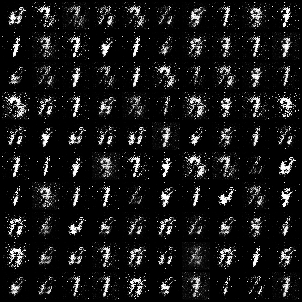

In [28]:
from PIL import Image

Image.open('./samples/sample.png')